## Setup

In [1]:
cd("$(homedir())/OneDrive/Documents/GitHub/enso_project.jl")
using Pkg
Pkg.activate(".")

  Activating project at `C:\Users\Andrea\OneDrive\Documents\GitHub\enso_project.jl`


In [2]:
using CSV, DataFrames, NODEData, SciMLBase, SciMLSensitivity, Random, Flux, OrdinaryDiffEq, enso_project

┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt C:\Users\Andrea\.julia\packages\Flux\3711C\ext\FluxCUDAExt\FluxCUDAExt.jl:10
┌ Warning: Circular dependency detected. Precompilation will be skipped for:
│   Base.PkgId(Base.UUID("e3ecd195-ca82-5397-9546-f380c1e34951"), "NonlinearSolveBaseSparseMatrixColoringsExt")
│   Base.PkgId(Base.UUID("385e4588-a1a0-5c1d-98fa-d45bf6f8ecf9"), "LinearSolveKernelAbstractionsExt")
│   Base.PkgId(Base.UUID("3bcf3b12-2128-5d18-8b3b-bcdd6f83637b"), "WeightInitializersGPUArraysExt")
│   Base.PkgId(Base.UUID("b00db79b-61e3-50fb-b26f-2d35b2d9e4ed"), "DiffEqBaseChainRulesCoreExt")
│   Base.PkgId(Base.UUID("8913a72c-1f9b-4ce2-8d82-65094dcecaec"), "NonlinearSolve")
│   Base.PkgId(Base.UUID("7edab7de-1038-5e4f-97a7-6bfc75d44324"), "NonlinearSolveQuasiNewt

### Data preparation

In [3]:
# read and convert data to appropriate format for all splits
splits = [20,40,50,60,70,80]
data = Dict() # of tuples (time,data)

for s in splits

    # set dict keys
    key_train = "train_data_$s"
    key_test = "test_data_$s"
    key_val = "val_data_$s"

    # read input data
    data[key_train] = CSV.read("data/sst_34_data_split_$s/train_sst_34_anomaly_embedded_$s.txt", DataFrame; delim=',', ignorerepeated=true)
    data[key_test] = CSV.read("data/sst_34_data_split_$s/test_sst_34_anomaly_embedded_$s.txt", DataFrame; delim=',', ignorerepeated=true)
    data[key_val] = CSV.read("data/sst_34_data_split_$s/val_sst_34_anomaly_embedded_$s.txt", DataFrame; delim=',', ignorerepeated=true)
   
    # format data, make sure everything is Float32
    data[key_train] = (time = Float32.(0:size(data[key_train],1)-1), data = Float32.(permutedims(data[key_train])))
    data[key_test] = (time = Float32.(0:size(data[key_test],1)-1), data = Float32.(permutedims(data[key_test])))
    data[key_val] = (time = Float32.(0:size(data[key_val],1)-1), data = Float32.(permutedims(data[key_val])))
end

data

Dict{Any, Any} with 18 entries:
  "val_data_60"   => (time = Float32[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.…
  "val_data_20"   => (time = Float32[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.…
  "train_data_70" => (time = Float32[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.…
  "test_data_40"  => (time = Float32[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.…
  "test_data_20"  => (time = Float32[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.…
  "train_data_80" => (time = Float32[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.…
  "test_data_80"  => (time = Float32[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.…
  "test_data_50"  => (time = Float32[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.…
  "val_data_50"   => (time = Float32[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.…
  "train_data_20" => (time = Float32[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.…
  "val_data_70"   => (time = Float32[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.…
  "test_data_70"  => (time = Float32[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 

### Storage for prediction results

We carry out predictions for 6 different data splits, where we keep the size of the test set always at the same proportion of 10%.

In [4]:
predictions_of_data_splits = zeros(6, length(data["test_data_20"].time))

6×49 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

## Train and Validate

### Hyperparameter range

Chosen based on hyperparameter optimization setup for package ChaoticNDETools.jl

In [5]:
sampler = enso_project.RandomSampler(N_weights=10:30, N_hidden_layers=1:4, activation=["relu","swish"], τ_max=2:4, eta=[1f-2,1f-3,1f-4])
N_epochs = 30
N_samples = 15
seeds = Vector(111:111:N_samples*111); # for reproducibility of results

### Training data split 20%

train = 20%,
val =  70%,
test = 10%

In [6]:
# convert into NODEData format, intialize batch sizes arbitrarily
train = NODEDataloader(Array(data["train_data_20"].data), data["train_data_20"].time, 2)
valid = NODEDataloader(Array(data["val_data_20"].data), data["val_data_20"].time, 2)
test = NODEDataloader(Array(data["test_data_20"].data), data["test_data_20"].time, 2)

NODEData{Matrix{Float32},Int64} with 48 batches with length 2

In [7]:
opt_loss, opt_hpars, opt_pars = enso_project.train_and_validate_node(train, valid, N_samples, N_epochs, seeds, sampler)

starting training with N_EPOCHS= 30 - N_weights=18 - N_hidden_layers=2 - activation=relu - τ_max=2 - η=0.001
Validation MSE = 0.8521963
starting training with N_EPOCHS= 30 - N_weights=14 - N_hidden_layers=3 - activation=swish - τ_max=3 - η=0.0001
starting training with N_EPOCHS= 30 - N_weights=14 - N_hidden_layers=3 - activation=swish - τ_max=3 - η=6.25e-6
Validation MSE = 9.855358
starting training with N_EPOCHS= 30 - N_weights=23 - N_hidden_layers=1 - activation=swish - τ_max=3 - η=0.01
starting training with N_EPOCHS= 30 - N_weights=23 - N_hidden_layers=1 - activation=swish - τ_max=3 - η=0.000625
Validation MSE = 0.8335096
starting training with N_EPOCHS= 30 - N_weights=22 - N_hidden_layers=4 - activation=swish - τ_max=3 - η=0.01
starting training with N_EPOCHS= 30 - N_weights=22 - N_hidden_layers=4 - activation=swish - τ_max=3 - η=0.000625
Validation MSE = 0.7624681
starting training with N_EPOCHS= 30 - N_weights=19 - N_hidden_layers=4 - activation=swish - τ_max=2 - η=0.0001
Valida

((0.7269849f0, 6), Dict{Symbol, Any}(:N_hidden_layers => 2, :activation => "swish", :τ_max => 2, :N_weights => 22, :eta => 0.001f0), Float32[-0.056989737, 0.32404688, -0.3873647, 0.20208456, 0.2867657, -0.29667634, -0.13393652, -0.37251744, -0.31754398, 0.12967706  …  -0.5165339, 0.27118617, -0.26649374, -0.30623844, -0.2829004, -0.0047860164, -0.010755775, -0.015570271, -0.016370967, -0.012245096])

### Predicting data split 20%

##### Set up optimal model

Execute first commented-out block if do not want to rerun train & validation.

In [ ]:
#using JLD2
#model_prep = load_object("data/nde_models/model_20.jld2")
#opt_pars = model_prep.p
#opt_loss = (0.7269849f0, 6)
#opt_hpars = Dict{Symbol, Any}(:N_hidden_layers => 2, :activation => "swish", :τ_max => 2, :N_weights => 22, :eta => 0.001f0)

p, re_nn = enso_project.setup_nn(opt_hpars[:N_weights],opt_hpars[:N_hidden_layers],opt_hpars[:activation],seeds[opt_loss[2]]) # network struct with optimal hyperpars

u0 = Vector(train.data[:,1])
dt = train.t[2] - train.t[1]
node_prob = enso_project.setup_node(opt_pars,re_nn,u0,dt) # NODE problem with optimal pars

model = enso_project.ChaoticNDE(node_prob);

Save intermediate results for continuing work without having to rerun things:

In [ ]:
using JLD2
save_object("data/nde_models/model_20.jld2", model)

┌ Warning: Attempting to store enso_project.var"#neural_ode#8"{Optimisers.Restructure{Chain{Tuple{Dense{typeof(swish), Matrix{Float32}, Vector{Float32}}, Dense{typeof(swish), Matrix{Float32}, Vector{Float32}}, Dense{typeof(swish), Matrix{Float32}, Vector{Float32}}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}}}, @NamedTuple{layers::NTuple{4, @NamedTuple{weight::Int64, bias::Int64, σ::Tuple{}}}}}}.
│ JLD2 only stores functions by name.
│  This may not be useful for anonymous functions.
└ @ JLD2 C:\Users\Andrea\.julia\packages\JLD2\nPYlZ\src\data\writing_datatypes.jl:447
┌ Warning: Attempting to store enso_project.var"#basic_tgrad#9".
│ JLD2 only stores functions by name.
│  This may not be useful for anonymous functions.
└ @ JLD2 C:\Users\Andrea\.julia\packages\JLD2\nPYlZ\src\data\writing_datatypes.jl:447
┌ Warning: Attempting to store ODEFunction{false, SciMLBase.FullSpecialize, enso_project.var"#neural_ode#8"{Optimisers.Restructure{Chain{Tuple{Dense{typeof(swish), Matrix{

##### Evaluate optimal model

We are only interested in the model's forecasting performance on the testing set for the first dimension, the original time-series before embedding, which we have real-word measurement for.
To evaluate the model we plot the prediction against the actual data to see to what extent they are in agreement and we calculate the average forecast length, which is an evaluation metric of the model's forecasting performance. For this we use the normalized prediction error with threshold 0.4 and take whole test set into account.

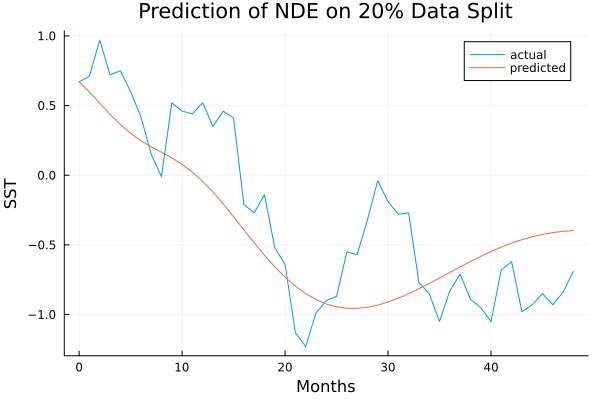

6×49 Matrix{Float64}:
 0.67  0.596934  0.516621  0.436734  …  -0.411612  -0.402516  -0.397154
 0.0   0.0       0.0       0.0           0.0        0.0        0.0
 0.0   0.0       0.0       0.0           0.0        0.0        0.0
 0.0   0.0       0.0       0.0           0.0        0.0        0.0
 0.0   0.0       0.0       0.0           0.0        0.0        0.0
 0.0   0.0       0.0       0.0       …   0.0        0.0        0.0

In [10]:
predictions_of_data_splits[1,:] = enso_project.predict_node(model, test, "20% Data Split")
predictions_of_data_splits

In [11]:
# only first dimension considered
enso_project.average_forecast_length(model, test.t, test.data, "1D", length(test.t)-1; λ_max = 0, mode = "norm")

1.0

### Training data split 40%

train = 40%,
val =  50%,
test = 10%

In [14]:
# convert into NODEData format, intialize batch sizes arbitrarily
train = NODEDataloader(Array(data["train_data_40"].data), data["train_data_40"].time, 2)
valid = NODEDataloader(Array(data["val_data_40"].data), data["val_data_40"].time, 2)
test = NODEDataloader(Array(data["test_data_40"].data), data["test_data_40"].time, 2)

NODEData{Matrix{Float32},Int64} with 48 batches with length 2

In [15]:
opt_loss, opt_hpars, opt_pars = enso_project.train_and_validate_node(train, valid, N_samples, N_epochs, seeds, sampler)

starting training with N_EPOCHS= 30 - N_weights=18 - N_hidden_layers=2 - activation=relu - τ_max=2 - η=0.001
Validation MSE = 0.56845903
starting training with N_EPOCHS= 30 - N_weights=14 - N_hidden_layers=3 - activation=swish - τ_max=3 - η=0.0001
starting training with N_EPOCHS= 30 - N_weights=14 - N_hidden_layers=3 - activation=swish - τ_max=3 - η=6.25e-6
Validation MSE = Inf
starting training with N_EPOCHS= 30 - N_weights=23 - N_hidden_layers=1 - activation=swish - τ_max=3 - η=0.01
starting training with N_EPOCHS= 30 - N_weights=23 - N_hidden_layers=1 - activation=swish - τ_max=3 - η=0.000625
Validation MSE = 0.6056289
starting training with N_EPOCHS= 30 - N_weights=22 - N_hidden_layers=4 - activation=swish - τ_max=3 - η=0.01
starting training with N_EPOCHS= 30 - N_weights=22 - N_hidden_layers=4 - activation=swish - τ_max=3 - η=0.000625
Validation MSE = 0.96692175
starting training with N_EPOCHS= 30 - N_weights=19 - N_hidden_layers=4 - activation=swish - τ_max=2 - η=0.0001
Validatio

((0.56845903f0, 1), Dict{Symbol, Any}(:N_hidden_layers => 2, :activation => "relu", :τ_max => 2, :N_weights => 18, :eta => 0.001f0), Float32[-0.16002552, 0.0670477, -0.03409458, -0.24469493, 0.43097743, -0.29202375, -0.47562996, -0.525219, -0.40829137, 0.07418562  …  -0.36595574, -0.1332009, -0.07197244, 0.13879919, 0.35925177, -0.014926906, 0.048660386, 0.1648378, 0.01705989, -0.012424752])

### Predicting data split 40%

##### Set up optimal model

Execute first commented-out block if do not want to rerun train & validation.

In [ ]:
#using JLD2
#model_prep = load_object("data/nde_models/model_40.jld2")
#opt_pars = model_prep.p
#opt_loss = (0.56845903f0, 1)
#opt_hpars = Dict{Symbol, Any}(:N_hidden_layers => 2, :activation => "relu", :τ_max => 2, :N_weights => 18, :eta => 0.001f0)

p, re_nn = enso_project.setup_nn(opt_hpars[:N_weights],opt_hpars[:N_hidden_layers],opt_hpars[:activation],seeds[opt_loss[2]]) # network struct with optimal hyperpars

u0 = Vector(train.data[:,1])
dt = train.t[2] - train.t[1]
node_prob = enso_project.setup_node(opt_pars,re_nn,u0,dt) # NODE problem with optimal pars

model = enso_project.ChaoticNDE(node_prob);

Save intermediate results for continuing work without having to rerun things:

In [17]:
using JLD2
save_object("data/nde_models/model_40.jld2", model)

┌ Warning: Attempting to store enso_project.var"#neural_ode#8"{Optimisers.Restructure{Chain{Tuple{Dense{typeof(relu), Matrix{Float32}, Vector{Float32}}, Dense{typeof(relu), Matrix{Float32}, Vector{Float32}}, Dense{typeof(relu), Matrix{Float32}, Vector{Float32}}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}}}, @NamedTuple{layers::NTuple{4, @NamedTuple{weight::Int64, bias::Int64, σ::Tuple{}}}}}}.
│ JLD2 only stores functions by name.
│  This may not be useful for anonymous functions.
└ @ JLD2 C:\Users\Andrea\.julia\packages\JLD2\nPYlZ\src\data\writing_datatypes.jl:447
┌ Warning: Attempting to store enso_project.var"#basic_tgrad#9".
│ JLD2 only stores functions by name.
│  This may not be useful for anonymous functions.
└ @ JLD2 C:\Users\Andrea\.julia\packages\JLD2\nPYlZ\src\data\writing_datatypes.jl:447
┌ Warning: Attempting to store ODEFunction{false, SciMLBase.FullSpecialize, enso_project.var"#neural_ode#8"{Optimisers.Restructure{Chain{Tuple{Dense{typeof(relu), Matrix{Floa

##### Evaluate optimal model

We are only interested in the model's forecasting performance on the testing set for the first dimension, the original time-series before embedding, which we have real-word measurement for.
To evaluate the model we plot the prediction against the actual data to see to what extent they are in agreement and we calculate the average forecast length, which is an evaluation metric of the model's forecasting performance. For this we use the normalized prediction error with threshold 0.4 and take whole test set into account.

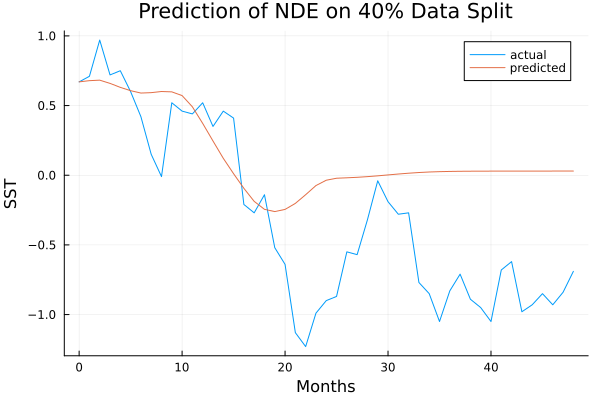

6×49 Matrix{Float64}:
 0.67  0.596934  0.516621  0.436734  …  -0.411612   -0.402516   -0.397154
 0.67  0.678611  0.682268  0.659081      0.0298085   0.0298172   0.0297925
 0.0   0.0       0.0       0.0           0.0         0.0         0.0
 0.0   0.0       0.0       0.0           0.0         0.0         0.0
 0.0   0.0       0.0       0.0           0.0         0.0         0.0
 0.0   0.0       0.0       0.0       …   0.0         0.0         0.0

In [18]:
predictions_of_data_splits[2,:] = enso_project.predict_node(model, test, "40% Data Split")
predictions_of_data_splits

In [20]:
# only first dimension considered
enso_project.average_forecast_length(model, test.t, test.data, "1D", length(test.t)-1; λ_max = 0, mode = "norm")

1.0

### Training data split 50%

train = 50%,
val =  40%,
test = 10%

In [21]:
# convert into NODEData format, intialize batch sizes arbitrarily
train = NODEDataloader(Array(data["train_data_50"].data), data["train_data_50"].time, 2)
valid = NODEDataloader(Array(data["val_data_50"].data), data["val_data_50"].time, 2)
test = NODEDataloader(Array(data["test_data_50"].data), data["test_data_50"].time, 2)

NODEData{Matrix{Float32},Int64} with 48 batches with length 2

In [22]:
opt_loss, opt_hpars, opt_pars = enso_project.train_and_validate_node(train, valid, N_samples, N_epochs, seeds, sampler)

starting training with N_EPOCHS= 30 - N_weights=18 - N_hidden_layers=2 - activation=relu - τ_max=2 - η=0.001
Validation MSE = 0.6354533
starting training with N_EPOCHS= 30 - N_weights=14 - N_hidden_layers=3 - activation=swish - τ_max=3 - η=0.0001
starting training with N_EPOCHS= 30 - N_weights=14 - N_hidden_layers=3 - activation=swish - τ_max=3 - η=6.25e-6
Validation MSE = 1.4805093
starting training with N_EPOCHS= 30 - N_weights=23 - N_hidden_layers=1 - activation=swish - τ_max=3 - η=0.01
starting training with N_EPOCHS= 30 - N_weights=23 - N_hidden_layers=1 - activation=swish - τ_max=3 - η=0.000625
Validation MSE = 0.6726338
starting training with N_EPOCHS= 30 - N_weights=22 - N_hidden_layers=4 - activation=swish - τ_max=3 - η=0.01
starting training with N_EPOCHS= 30 - N_weights=22 - N_hidden_layers=4 - activation=swish - τ_max=3 - η=0.000625
Validation MSE = 0.77615947
starting training with N_EPOCHS= 30 - N_weights=19 - N_hidden_layers=4 - activation=swish - τ_max=2 - η=0.0001
Vali

((0.61417884f0, 15), Dict{Symbol, Any}(:N_hidden_layers => 1, :activation => "relu", :τ_max => 2, :N_weights => 29, :eta => 0.001f0), Float32[0.2357443, -0.15230717, 0.22812194, -0.033409372, 0.35542575, 0.031349376, 0.3291822, -0.43242833, -0.3061055, 0.17557158  …  -0.08999699, 0.48454162, -0.040081393, 0.036063105, 0.046471704, -0.0018119956, -0.048040282, 0.017441988, 0.007447539, 0.038990486])

### Predicting data split 50%

##### Set up optimal model

Execute first commented-out block if do not want to rerun train & validation.

In [ ]:
#using JLD2
#model_prep = load_object("data/nde_models/model_50.jld2")
#opt_pars = model_prep.p
#opt_loss = (0.61417884f0, 15)
#opt_hpars = Dict{Symbol, Any}(:N_hidden_layers => 1, :activation => "relu", :τ_max => 2, :N_weights => 29, :eta => 0.001f0)

p, re_nn = enso_project.setup_nn(opt_hpars[:N_weights],opt_hpars[:N_hidden_layers],opt_hpars[:activation],seeds[opt_loss[2]]) # network struct with optimal hyperpars

u0 = Vector(train.data[:,1])
dt = train.t[2] - train.t[1]
node_prob = enso_project.setup_node(opt_pars,re_nn,u0,dt) # NODE problem with optimal pars

model = enso_project.ChaoticNDE(node_prob);

Save intermediate results for continuing work without having to rerun things:

In [24]:
using JLD2
save_object("data/nde_models/model_50.jld2", model)

┌ Warning: Attempting to store enso_project.var"#neural_ode#8"{Optimisers.Restructure{Chain{Tuple{Dense{typeof(relu), Matrix{Float32}, Vector{Float32}}, Dense{typeof(relu), Matrix{Float32}, Vector{Float32}}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}}}, @NamedTuple{layers::Tuple{@NamedTuple{weight::Int64, bias::Int64, σ::Tuple{}}, @NamedTuple{weight::Int64, bias::Int64, σ::Tuple{}}, @NamedTuple{weight::Int64, bias::Int64, σ::Tuple{}}}}}}.
│ JLD2 only stores functions by name.
│  This may not be useful for anonymous functions.
└ @ JLD2 C:\Users\Andrea\.julia\packages\JLD2\nPYlZ\src\data\writing_datatypes.jl:447
┌ Warning: Attempting to store enso_project.var"#basic_tgrad#9".
│ JLD2 only stores functions by name.
│  This may not be useful for anonymous functions.
└ @ JLD2 C:\Users\Andrea\.julia\packages\JLD2\nPYlZ\src\data\writing_datatypes.jl:447
┌ Warning: Attempting to store ODEFunction{false, SciMLBase.FullSpecialize, enso_project.var"#neural_ode#8"{Optimisers.Restruct

##### Evaluate optimal model

We are only interested in the model's forecasting performance on the testing set for the first dimension, the original time-series before embedding, which we have real-word measurement for.
To evaluate the model we plot the prediction against the actual data to see to what extent they are in agreement and we calculate the average forecast length, which is an evaluation metric of the model's forecasting performance. For this we use the normalized prediction error with threshold 0.4 and take whole test set into account.

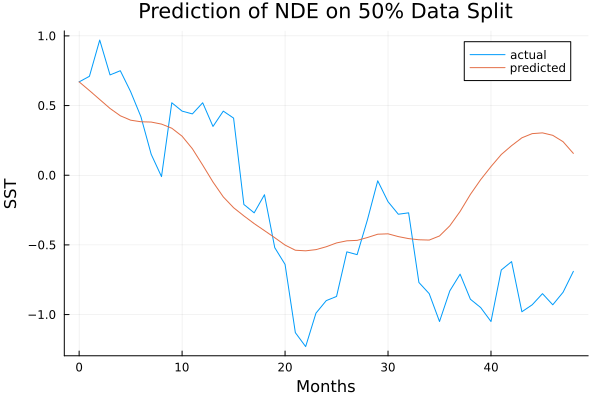

6×49 Matrix{Float64}:
 0.67  0.596934  0.516621  0.436734  …  -0.411612   -0.402516   -0.397154
 0.67  0.678611  0.682268  0.659081      0.0298085   0.0298172   0.0297925
 0.67  0.607601  0.543374  0.479199      0.286288    0.240593    0.156527
 0.0   0.0       0.0       0.0           0.0         0.0         0.0
 0.0   0.0       0.0       0.0           0.0         0.0         0.0
 0.0   0.0       0.0       0.0       …   0.0         0.0         0.0

In [25]:
predictions_of_data_splits[3,:] = enso_project.predict_node(model, test, "50% Data Split")
predictions_of_data_splits

In [27]:
# only first dimension considered
enso_project.average_forecast_length(model, test.t, test.data, "1D", length(test.t)-1; λ_max = 0, mode = "norm")

1.0

### Training data split 60%

train = 60%,
val =  30%,
test = 10%

In [28]:
# convert into NODEData format, intialize batch sizes arbitrarily
train = NODEDataloader(Array(data["train_data_60"].data), data["train_data_60"].time, 2)
valid = NODEDataloader(Array(data["val_data_60"].data), data["val_data_60"].time, 2)
test = NODEDataloader(Array(data["test_data_60"].data), data["test_data_60"].time, 2)

NODEData{Matrix{Float32},Int64} with 48 batches with length 2

In [29]:
opt_loss, opt_hpars, opt_pars = enso_project.train_and_validate_node(train, valid, N_samples, N_epochs, seeds, sampler)

starting training with N_EPOCHS= 30 - N_weights=18 - N_hidden_layers=2 - activation=relu - τ_max=2 - η=0.001
Validation MSE = 0.69957966
starting training with N_EPOCHS= 30 - N_weights=14 - N_hidden_layers=3 - activation=swish - τ_max=3 - η=0.0001
starting training with N_EPOCHS= 30 - N_weights=14 - N_hidden_layers=3 - activation=swish - τ_max=3 - η=6.25e-6
Validation MSE = 0.8025259
starting training with N_EPOCHS= 30 - N_weights=23 - N_hidden_layers=1 - activation=swish - τ_max=3 - η=0.01
starting training with N_EPOCHS= 30 - N_weights=23 - N_hidden_layers=1 - activation=swish - τ_max=3 - η=0.000625
Validation MSE = 0.5875463
starting training with N_EPOCHS= 30 - N_weights=22 - N_hidden_layers=4 - activation=swish - τ_max=3 - η=0.01
starting training with N_EPOCHS= 30 - N_weights=22 - N_hidden_layers=4 - activation=swish - τ_max=3 - η=0.000625
Validation MSE = 0.6496703
starting training with N_EPOCHS= 30 - N_weights=19 - N_hidden_layers=4 - activation=swish - τ_max=2 - η=0.0001
Vali

((0.5107755f0, 15), Dict{Symbol, Any}(:N_hidden_layers => 1, :activation => "relu", :τ_max => 2, :N_weights => 29, :eta => 0.001f0), Float32[0.21863951, -0.13489096, 0.2417675, -0.03314691, 0.36546102, 0.028199024, 0.3288456, -0.4355422, -0.2935565, 0.18620732  …  -0.074620426, 0.48621804, 0.019297978, 0.06738779, -0.02728027, -0.015161152, -0.07058467, 0.016201824, 0.0068989564, 0.043063838])

### Predicting data split 60%

##### Set up optimal model

Execute first commented-out block if do not want to rerun train & validation.

In [ ]:
#using JLD2
#model_prep = load_object("data/nde_models/model_60.jld2")
#opt_pars = model_prep.p
#opt_loss = (0.5107755f0, 15)
#opt_hpars = Dict{Symbol, Any}(:N_hidden_layers => 1, :activation => "relu", :τ_max => 2, :N_weights => 29, :eta => 0.001f0)

p, re_nn = enso_project.setup_nn(opt_hpars[:N_weights],opt_hpars[:N_hidden_layers],opt_hpars[:activation],seeds[opt_loss[2]]) # network struct with optimal hyperpars

u0 = Vector(train.data[:,1])
dt = train.t[2] - train.t[1]
node_prob = enso_project.setup_node(opt_pars,re_nn,u0,dt) # NODE problem with optimal pars

model = enso_project.ChaoticNDE(node_prob);

Save intermediate results for continuing work without having to rerun things:

In [31]:
using JLD2
save_object("data/nde_models/model_60.jld2", model)

┌ Warning: Attempting to store enso_project.var"#neural_ode#8"{Optimisers.Restructure{Chain{Tuple{Dense{typeof(relu), Matrix{Float32}, Vector{Float32}}, Dense{typeof(relu), Matrix{Float32}, Vector{Float32}}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}}}, @NamedTuple{layers::Tuple{@NamedTuple{weight::Int64, bias::Int64, σ::Tuple{}}, @NamedTuple{weight::Int64, bias::Int64, σ::Tuple{}}, @NamedTuple{weight::Int64, bias::Int64, σ::Tuple{}}}}}}.
│ JLD2 only stores functions by name.
│  This may not be useful for anonymous functions.
└ @ JLD2 C:\Users\Andrea\.julia\packages\JLD2\nPYlZ\src\data\writing_datatypes.jl:447
┌ Warning: Attempting to store enso_project.var"#basic_tgrad#9".
│ JLD2 only stores functions by name.
│  This may not be useful for anonymous functions.
└ @ JLD2 C:\Users\Andrea\.julia\packages\JLD2\nPYlZ\src\data\writing_datatypes.jl:447
┌ Warning: Attempting to store ODEFunction{false, SciMLBase.FullSpecialize, enso_project.var"#neural_ode#8"{Optimisers.Restruct

##### Evaluate optimal model

We are only interested in the model's forecasting performance on the testing set for the first dimension, the original time-series before embedding, which we have real-word measurement for.
To evaluate the model we plot the prediction against the actual data to see to what extent they are in agreement and we calculate the average forecast length, which is an evaluation metric of the model's forecasting performance. For this we use the normalized prediction error with threshold 0.4 and take whole test set into account.

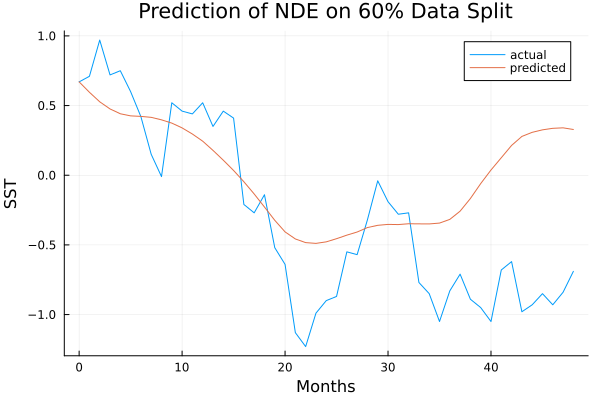

6×49 Matrix{Float64}:
 0.67  0.596934  0.516621  0.436734  …  -0.411612   -0.402516   -0.397154
 0.67  0.678611  0.682268  0.659081      0.0298085   0.0298172   0.0297925
 0.67  0.607601  0.543374  0.479199      0.286288    0.240593    0.156527
 0.67  0.595257  0.526875  0.475683      0.336578    0.340075    0.328228
 0.0   0.0       0.0       0.0           0.0         0.0         0.0
 0.0   0.0       0.0       0.0       …   0.0         0.0         0.0

In [32]:
predictions_of_data_splits[4,:] = enso_project.predict_node(model, test, "60% Data Split")
predictions_of_data_splits

In [34]:
# only first dimension considered
enso_project.average_forecast_length(model, test.t, test.data, "1D", length(test.t)-1; λ_max = 0, mode = "norm")

1.0

### Training data split 70%

train = 70%,
val =  20%,
test = 10%

In [35]:
# convert into NODEData format, intialize batch sizes arbitrarily
train = NODEDataloader(Array(data["train_data_70"].data), data["train_data_70"].time, 2)
valid = NODEDataloader(Array(data["val_data_70"].data), data["val_data_70"].time, 2)
test = NODEDataloader(Array(data["test_data_70"].data), data["test_data_70"].time, 2)

NODEData{Matrix{Float32},Int64} with 48 batches with length 2

In [36]:
opt_loss, opt_hpars, opt_pars = enso_project.train_and_validate_node(train, valid, N_samples, N_epochs, seeds, sampler)

starting training with N_EPOCHS= 30 - N_weights=18 - N_hidden_layers=2 - activation=relu - τ_max=2 - η=0.001
Validation MSE = 0.6504237
starting training with N_EPOCHS= 30 - N_weights=14 - N_hidden_layers=3 - activation=swish - τ_max=3 - η=0.0001
starting training with N_EPOCHS= 30 - N_weights=14 - N_hidden_layers=3 - activation=swish - τ_max=3 - η=6.25e-6
Validation MSE = 1.2751278
starting training with N_EPOCHS= 30 - N_weights=23 - N_hidden_layers=1 - activation=swish - τ_max=3 - η=0.01
starting training with N_EPOCHS= 30 - N_weights=23 - N_hidden_layers=1 - activation=swish - τ_max=3 - η=0.000625
Validation MSE = 0.62411976
starting training with N_EPOCHS= 30 - N_weights=22 - N_hidden_layers=4 - activation=swish - τ_max=3 - η=0.01
starting training with N_EPOCHS= 30 - N_weights=22 - N_hidden_layers=4 - activation=swish - τ_max=3 - η=0.000625
Validation MSE = 0.5897622
starting training with N_EPOCHS= 30 - N_weights=19 - N_hidden_layers=4 - activation=swish - τ_max=2 - η=0.0001
Vali

((0.58904266f0, 15), Dict{Symbol, Any}(:N_hidden_layers => 1, :activation => "relu", :τ_max => 2, :N_weights => 29, :eta => 0.001f0), Float32[0.22130403, -0.12772495, 0.24843664, -0.033080686, 0.37338218, 0.033586185, 0.3167817, -0.41484076, -0.293725, 0.19810855  …  -0.054488353, 0.4765005, -0.07298946, 0.07248935, -0.0903769, -0.01871911, -0.061538506, 0.013818303, 0.02492539, 0.027147233])

### Predicting data split 70%

##### Set up optimal model

Execute first commented-out block if do not want to rerun train & validation.

In [ ]:
#using JLD2
#model_prep = load_object("data/nde_models/model_70.jld2")
#opt_pars = model_prep.p
#opt_loss = (0.58904266f0, 15)
#opt_hpars = Dict{Symbol, Any}(:N_hidden_layers => 1, :activation => "relu", :τ_max => 2, :N_weights => 29, :eta => 0.001f0)

p, re_nn = enso_project.setup_nn(opt_hpars[:N_weights],opt_hpars[:N_hidden_layers],opt_hpars[:activation],seeds[opt_loss[2]]) # network struct with optimal hyperpars

u0 = Vector(train.data[:,1])
dt = train.t[2] - train.t[1]
node_prob = enso_project.setup_node(opt_pars,re_nn,u0,dt) # NODE problem with optimal pars

model = enso_project.ChaoticNDE(node_prob);

Save intermediate results for continuing work without having to rerun things:

In [38]:
using JLD2
save_object("data/nde_models/model_70.jld2", model)

┌ Warning: Attempting to store enso_project.var"#neural_ode#8"{Optimisers.Restructure{Chain{Tuple{Dense{typeof(relu), Matrix{Float32}, Vector{Float32}}, Dense{typeof(relu), Matrix{Float32}, Vector{Float32}}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}}}, @NamedTuple{layers::Tuple{@NamedTuple{weight::Int64, bias::Int64, σ::Tuple{}}, @NamedTuple{weight::Int64, bias::Int64, σ::Tuple{}}, @NamedTuple{weight::Int64, bias::Int64, σ::Tuple{}}}}}}.
│ JLD2 only stores functions by name.
│  This may not be useful for anonymous functions.
└ @ JLD2 C:\Users\Andrea\.julia\packages\JLD2\nPYlZ\src\data\writing_datatypes.jl:447
┌ Warning: Attempting to store enso_project.var"#basic_tgrad#9".
│ JLD2 only stores functions by name.
│  This may not be useful for anonymous functions.
└ @ JLD2 C:\Users\Andrea\.julia\packages\JLD2\nPYlZ\src\data\writing_datatypes.jl:447
┌ Warning: Attempting to store ODEFunction{false, SciMLBase.FullSpecialize, enso_project.var"#neural_ode#8"{Optimisers.Restruct

##### Evaluate optimal model

We are only interested in the model's forecasting performance on the testing set for the first dimension, the original time-series before embedding, which we have real-word measurement for.
To evaluate the model we plot the prediction against the actual data to see to what extent they are in agreement and we calculate the average forecast length, which is an evaluation metric of the model's forecasting performance. For this we use the normalized prediction error with threshold 0.4 and take whole test set into account.

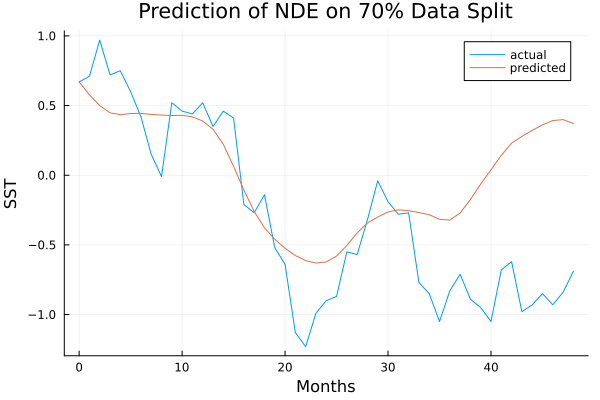

6×49 Matrix{Float64}:
 0.67  0.596934  0.516621  0.436734  …  -0.411612   -0.402516   -0.397154
 0.67  0.678611  0.682268  0.659081      0.0298085   0.0298172   0.0297925
 0.67  0.607601  0.543374  0.479199      0.286288    0.240593    0.156527
 0.67  0.595257  0.526875  0.475683      0.336578    0.340075    0.328228
 0.67  0.577036  0.499405  0.448087      0.392175    0.399161    0.370961
 0.0   0.0       0.0       0.0       …   0.0         0.0         0.0

In [39]:
predictions_of_data_splits[5,:] = enso_project.predict_node(model, test, "70% Data Split")
predictions_of_data_splits

In [40]:
# only first dimension considered
enso_project.average_forecast_length(model, test.t, test.data, "1D", length(test.t)-1; λ_max = 0, mode = "norm")

1.0

### Training data split 80%

train = 80%,
val =  10%,
test = 10%

In [41]:
# convert into NODEData format, intialize batch sizes arbitrarily
train = NODEDataloader(Array(data["train_data_80"].data), data["train_data_80"].time, 2)
valid = NODEDataloader(Array(data["val_data_80"].data), data["val_data_80"].time, 2)
test = NODEDataloader(Array(data["test_data_80"].data), data["test_data_80"].time, 2)

NODEData{Matrix{Float32},Int64} with 48 batches with length 2

In [42]:
opt_loss, opt_hpars, opt_pars = enso_project.train_and_validate_node(train, valid, N_samples, N_epochs, seeds, sampler)

starting training with N_EPOCHS= 30 - N_weights=18 - N_hidden_layers=2 - activation=relu - τ_max=2 - η=0.001
Validation MSE = 0.5897454
starting training with N_EPOCHS= 30 - N_weights=14 - N_hidden_layers=3 - activation=swish - τ_max=3 - η=0.0001
starting training with N_EPOCHS= 30 - N_weights=14 - N_hidden_layers=3 - activation=swish - τ_max=3 - η=6.25e-6
Validation MSE = 4.272054
starting training with N_EPOCHS= 30 - N_weights=23 - N_hidden_layers=1 - activation=swish - τ_max=3 - η=0.01
starting training with N_EPOCHS= 30 - N_weights=23 - N_hidden_layers=1 - activation=swish - τ_max=3 - η=0.000625
Validation MSE = 0.4541883
starting training with N_EPOCHS= 30 - N_weights=22 - N_hidden_layers=4 - activation=swish - τ_max=3 - η=0.01
starting training with N_EPOCHS= 30 - N_weights=22 - N_hidden_layers=4 - activation=swish - τ_max=3 - η=0.000625
Validation MSE = 0.61601925
starting training with N_EPOCHS= 30 - N_weights=19 - N_hidden_layers=4 - activation=swish - τ_max=2 - η=0.0001
Valid

((0.29774836f0, 6), Dict{Symbol, Any}(:N_hidden_layers => 2, :activation => "swish", :τ_max => 2, :N_weights => 22, :eta => 0.001f0), Float32[-0.08326853, 0.37472114, -0.38979203, 0.22094841, 0.29596794, -0.25910228, -0.13144855, -0.38315943, -0.4251144, 0.16712134  …  -0.5640003, 0.22073978, -0.18706118, -0.33586958, -0.22638987, -0.0023709289, -0.006136701, 0.00473459, -0.010572327, 0.0033436345])

### Predicting data split 80%

##### Set up optimal model

Execute first commented-out block if do not want to rerun train & validation.

In [ ]:
#using JLD2
#model_prep = load_object("data/nde_models/model_80.jld2")
#opt_pars = model_prep.p
#opt_loss = (0.29774836f0, 6)
#opt_hpars = Dict{Symbol, Any}(:N_hidden_layers => 2, :activation => "swish", :τ_max => 2, :N_weights => 22, :eta => 0.001f0)

p, re_nn = enso_project.setup_nn(opt_hpars[:N_weights],opt_hpars[:N_hidden_layers],opt_hpars[:activation],seeds[opt_loss[2]]) # network struct with optimal hyperpars

u0 = Vector(train.data[:,1])
dt = train.t[2] - train.t[1]
node_prob = enso_project.setup_node(opt_pars,re_nn,u0,dt) # NODE problem with optimal pars

model = enso_project.ChaoticNDE(node_prob);

Save intermediate results for continuing work without having to rerun things:

In [44]:
using JLD2
save_object("data/nde_models/model_80.jld2", model)

┌ Warning: Attempting to store enso_project.var"#neural_ode#8"{Optimisers.Restructure{Chain{Tuple{Dense{typeof(swish), Matrix{Float32}, Vector{Float32}}, Dense{typeof(swish), Matrix{Float32}, Vector{Float32}}, Dense{typeof(swish), Matrix{Float32}, Vector{Float32}}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}}}, @NamedTuple{layers::NTuple{4, @NamedTuple{weight::Int64, bias::Int64, σ::Tuple{}}}}}}.
│ JLD2 only stores functions by name.
│  This may not be useful for anonymous functions.
└ @ JLD2 C:\Users\Andrea\.julia\packages\JLD2\nPYlZ\src\data\writing_datatypes.jl:447
┌ Warning: Attempting to store enso_project.var"#basic_tgrad#9".
│ JLD2 only stores functions by name.
│  This may not be useful for anonymous functions.
└ @ JLD2 C:\Users\Andrea\.julia\packages\JLD2\nPYlZ\src\data\writing_datatypes.jl:447
┌ Warning: Attempting to store ODEFunction{false, SciMLBase.FullSpecialize, enso_project.var"#neural_ode#8"{Optimisers.Restructure{Chain{Tuple{Dense{typeof(swish), Matrix{

##### Evaluate optimal model

We are only interested in the model's forecasting performance on the testing set for the first dimension, the original time-series before embedding, which we have real-word measurement for.
To evaluate the model we plot the prediction against the actual data to see to what extent they are in agreement and we calculate the average forecast length, which is an evaluation metric of the model's forecasting performance. For this we use the normalized prediction error with threshold 0.4 and take whole test set into account.

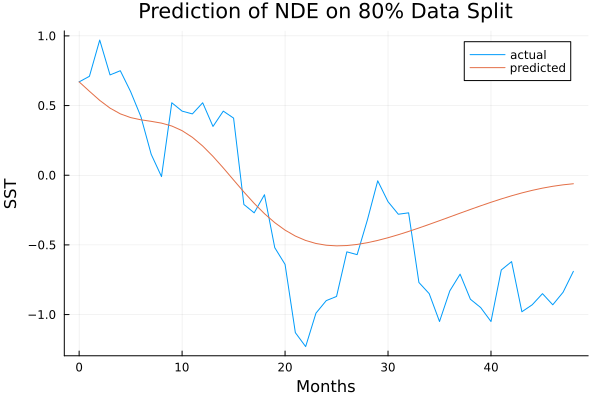

6×49 Matrix{Float64}:
 0.67  0.596934  0.516621  0.436734  …  -0.411612   -0.402516   -0.397154
 0.67  0.678611  0.682268  0.659081      0.0298085   0.0298172   0.0297925
 0.67  0.607601  0.543374  0.479199      0.286288    0.240593    0.156527
 0.67  0.595257  0.526875  0.475683      0.336578    0.340075    0.328228
 0.67  0.577036  0.499405  0.448087      0.392175    0.399161    0.370961
 0.67  0.602503  0.536996  0.481544  …  -0.079476   -0.0689454  -0.0611897

In [45]:
predictions_of_data_splits[6,:] = enso_project.predict_node(model, test, "80% Data Split")
predictions_of_data_splits

In [46]:
# only first dimension considered
enso_project.average_forecast_length(model, test.t, test.data, "1D", length(test.t)-1; λ_max = 0, mode = "norm")

1.0

## Comparison of data splits

Execute commented-out part if do not want to rerun all predictions.

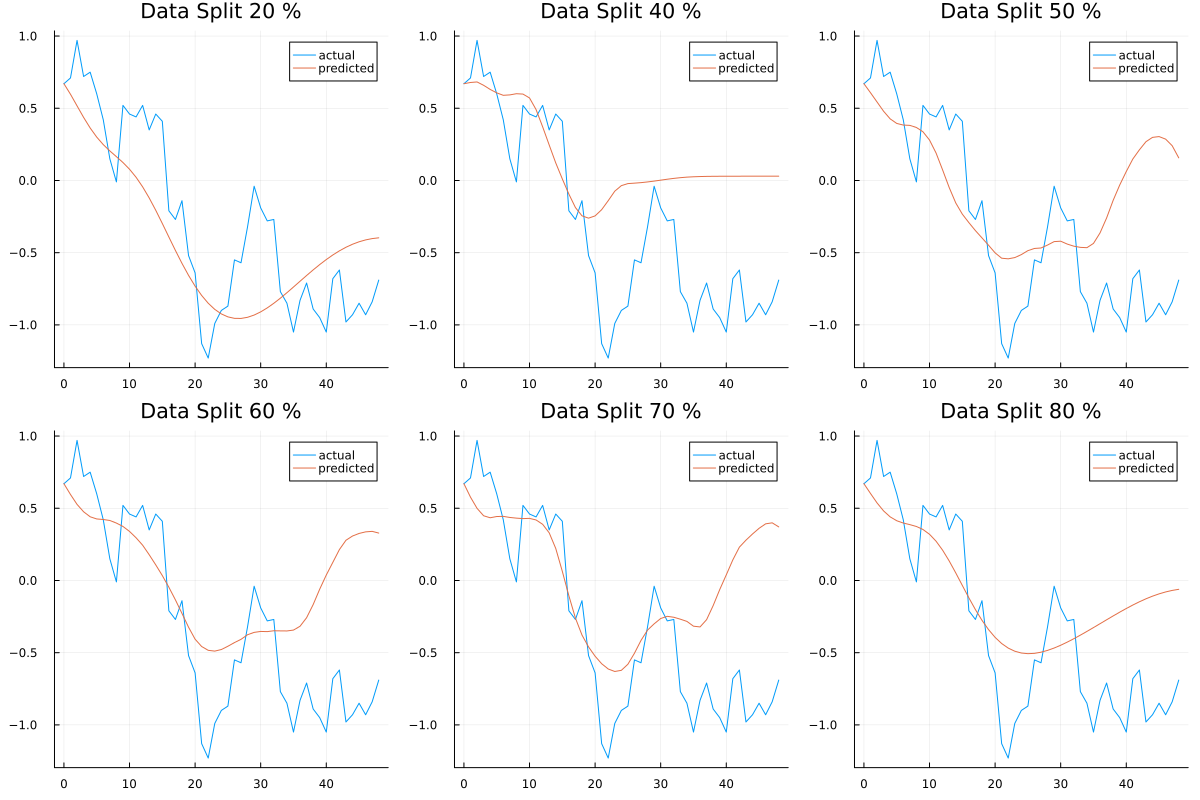

In [ ]:
#using JLD2
#predictions_of_data_splits = load_object("data/nde_models/model_predictions.jld2")
enso_project.plot_data_split_predictions(predictions_of_data_splits, Matrix(data["test_data_20"].data), splits)

Save intermediate results for continuing work without having to rerun things:

In [48]:
using JLD2
save_object("data/nde_models/model_predictions.jld2", predictions_of_data_splits)

### Retrain optimal model for data split 80%

We retrain the model using the optimal hyperparameters on both the training and validation data. This is necessary because we don't want errors occurred during validation to affect the test error and we want our final model at its best performance.

The 'Validation MSE' means in this case the overall MSE loss on the merged training and validation data. (see def. of retrain_node)

In [50]:
opt_pars_re, mse_trainval = enso_project.retrain_node(train, valid, N_epochs, opt_hpars[:N_weights], opt_hpars[:N_hidden_layers], 
opt_hpars[:activation], opt_hpars[:τ_max], opt_hpars[:eta], seeds[opt_loss[2]])

starting training with N_EPOCHS= 30 - N_weights=22 - N_hidden_layers=2 - activation=swish - τ_max=2 - η=0.001
Validation MSE = 0.66793245


(Float32[-0.042060424, 0.3698244, -0.35068065, 0.22267021, 0.29988483, -0.23365398, -0.0950644, -0.3730963, -0.4012872, 0.16159551  …  -0.5691301, 0.2255987, -0.19572508, -0.32387975, -0.1988852, -0.0052263504, -0.005401083, 0.003155822, -0.011579207, 0.0059146527], 0.66793245f0)

Set up optimal retrained model

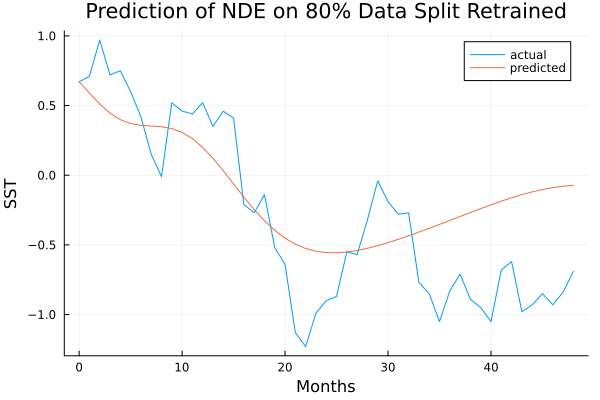

In [51]:
p, re_nn = enso_project.setup_nn(opt_hpars[:N_weights],opt_hpars[:N_hidden_layers],opt_hpars[:activation],seeds[opt_loss[2]]) # network struct with optimal hyperpars

u0 = Vector(train.data[:,1])
dt = train.t[2] - train.t[1]
node_prob = enso_project.setup_node(opt_pars_re,re_nn,u0,dt) # NODE problem with optimal pars

model_re = enso_project.ChaoticNDE(node_prob)
prediction_80_re = enso_project.predict_node(model_re, test, "80% Data Split Retrained");

In [62]:
prediction = permutedims(Array(prediction_80_re))
truth = permutedims(Array(data["test_data_80"].data[1,:]));

In [63]:
errors = abs.(prediction .- truth)

1×49 Matrix{Float32}:
 0.0  0.120164  0.45888  0.274527  0.351292  …  0.840884  0.761025  0.617615

In [64]:
enso_project.forecast_δ_1D(prediction, truth, "1D", "norm")

1-element Vector{Float32}:
 0.6470602

In [66]:
enso_project.forecast_δ_1D(prediction, truth, "1D", "both")

(Float32[0.37888157], Float32[0.8408841])

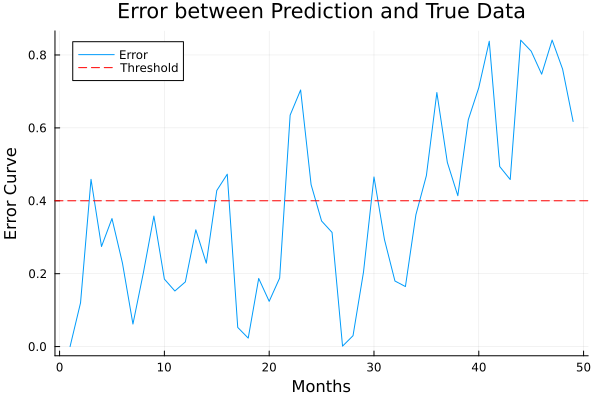

In [67]:
enso_project.plot_error_curve(errors, 0.4)

In [69]:
findfirst(errors .> 0.5)

CartesianIndex(1, 22)

In [73]:
findfirst(errors .> 0.4)

CartesianIndex(1, 3)

Save retrained 80% model

In [74]:
using JLD2
save_object("data/nde_models/model_80_re.jld2", model_re)

┌ Warning: Attempting to store enso_project.var"#neural_ode#8"{Optimisers.Restructure{Chain{Tuple{Dense{typeof(swish), Matrix{Float32}, Vector{Float32}}, Dense{typeof(swish), Matrix{Float32}, Vector{Float32}}, Dense{typeof(swish), Matrix{Float32}, Vector{Float32}}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}}}, @NamedTuple{layers::NTuple{4, @NamedTuple{weight::Int64, bias::Int64, σ::Tuple{}}}}}}.
│ JLD2 only stores functions by name.
│  This may not be useful for anonymous functions.
└ @ JLD2 C:\Users\Andrea\.julia\packages\JLD2\nPYlZ\src\data\writing_datatypes.jl:447
┌ Warning: Attempting to store enso_project.var"#basic_tgrad#9".
│ JLD2 only stores functions by name.
│  This may not be useful for anonymous functions.
└ @ JLD2 C:\Users\Andrea\.julia\packages\JLD2\nPYlZ\src\data\writing_datatypes.jl:447
┌ Warning: Attempting to store ODEFunction{false, SciMLBase.FullSpecialize, enso_project.var"#neural_ode#8"{Optimisers.Restructure{Chain{Tuple{Dense{typeof(swish), Matrix{